# 读取数据去重

In [1]:
from common import read
city = '北京'
df = read(city)

data/chengjiao-北京/2019-08-02-北京.xls
data/chengjiao-北京/2019-08-03-北京.xls
data/chengjiao-北京/2019-08-07-北京.xls
data/chengjiao-北京/2019-08-09-北京.xls
data/chengjiao-北京/2019-08-16-北京.xls
data/chengjiao-北京/2019-08-22-北京.xls
data/chengjiao-北京/all.csv
data/chengjiao-北京/chengjiao-2019-08-01-北京.xls
data/chengjiao-北京/北京.csv


/Users/alex/Quant/code/LianjiaSpider/common.py:86: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df = pd.concat(dfs)


525967


In [7]:
df.to_csv('%s.csv'%city, index=False)

In [4]:
xiaoqu= open('csxiaoqu.txt', 'w')
xiaoquList = df['小区'].unique()
print(len(xiaoquList))
for xq in xiaoquList:
    xiaoqu.write(xq+'\n')
    
xiaoqu.close()

839


In [5]:
df['下辖区'].unique()

array(['雨花', '望城', '天心', '芙蓉', '开福', '长沙县', '岳麓'], dtype=object)

有电梯 303857
无电梯 222110


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


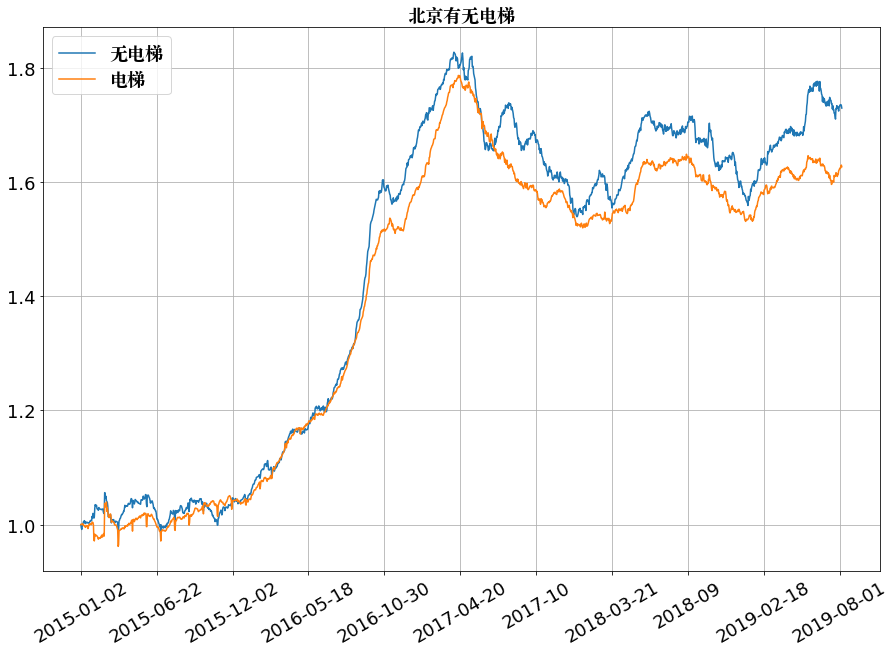

In [2]:
from common import plot_dfs
import pandas as pd
pd.options.display.max_columns = None
df_dt= df.loc[df['电梯'] == '有']
df_ndt= df.loc[df['电梯'] != '有']
print('有电梯', len(df_dt))
print('无电梯',len(df_ndt))
plot_dfs([df_ndt,df_dt], '%s有无电梯'%city, ['无电梯', '电梯'], 30, '2015-01-01')

# 计算全市日均价与成交量序列并作图

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


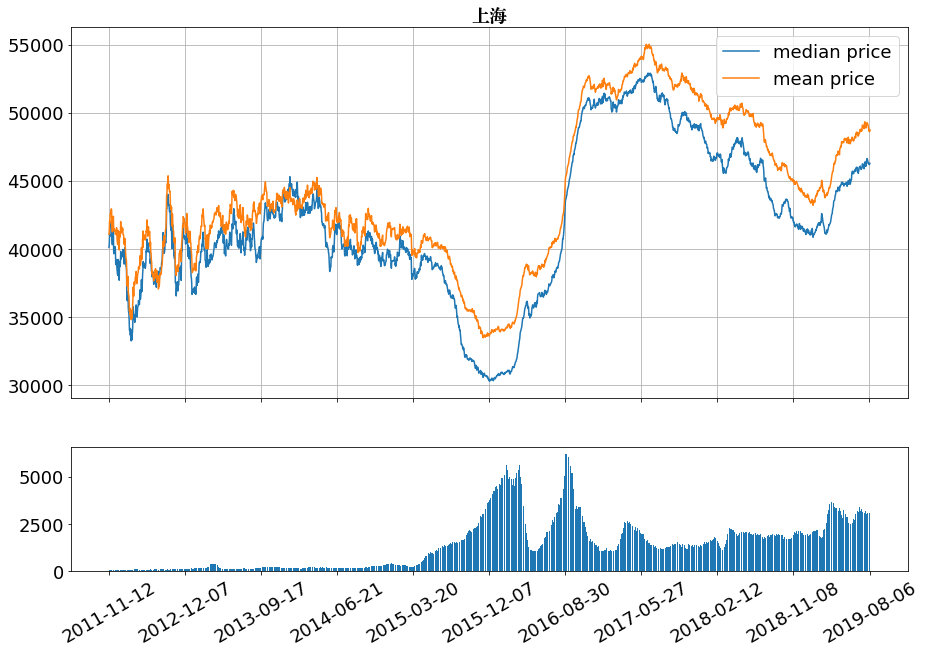

长宁


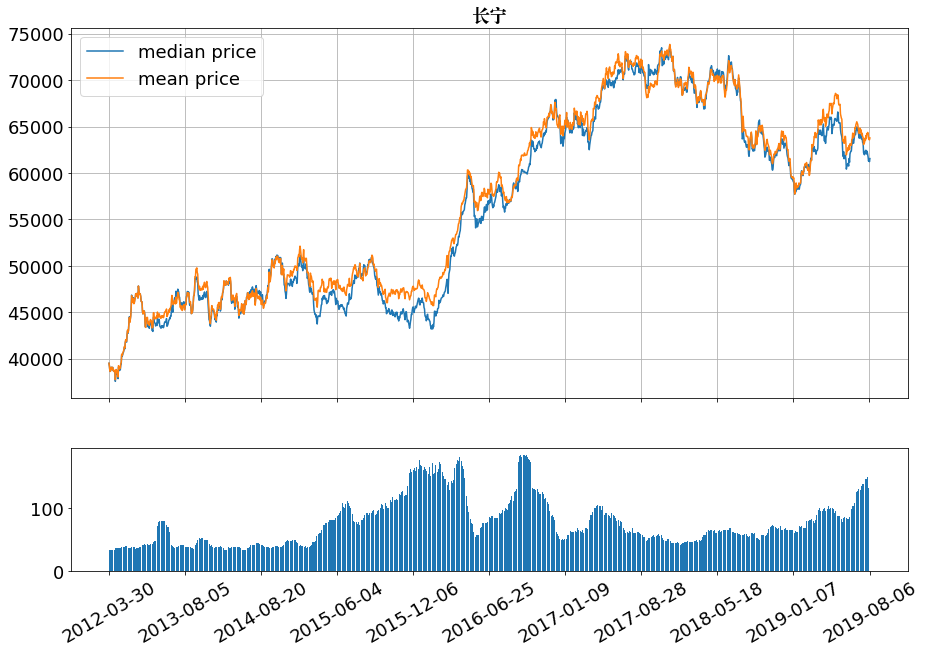

徐汇


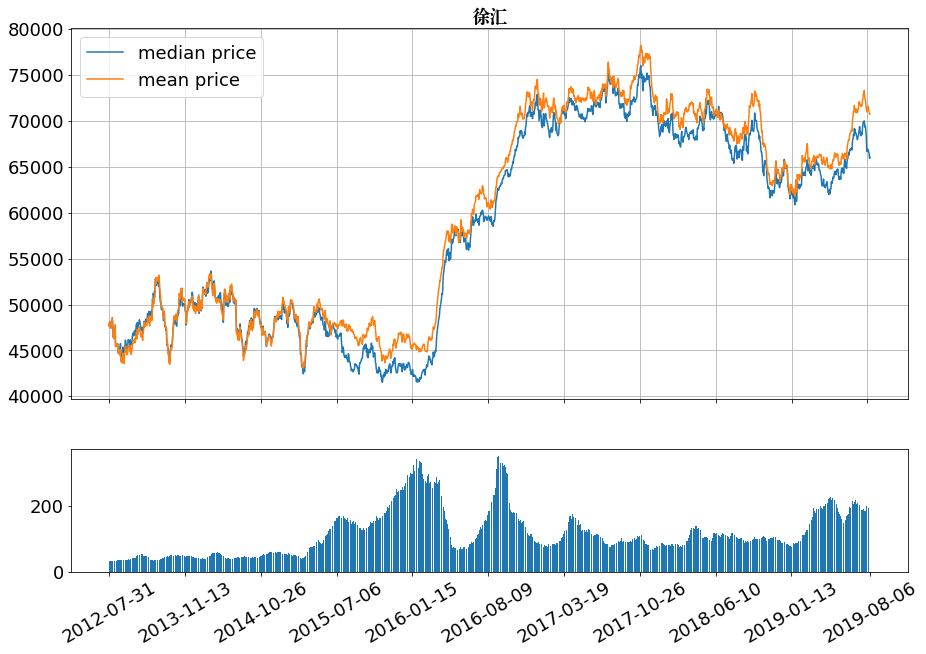

黄浦


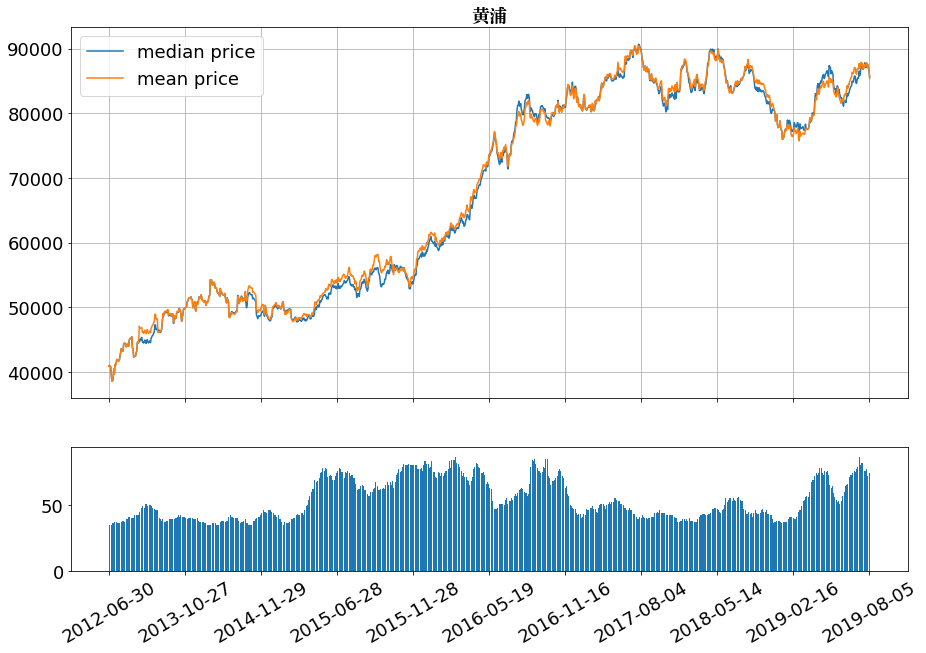

宝山


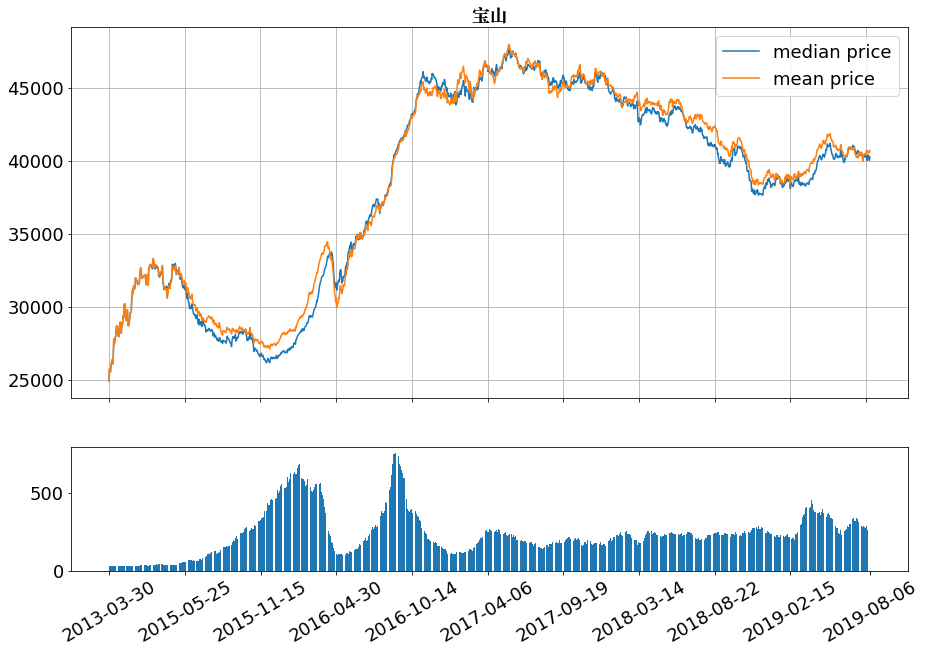

闵行


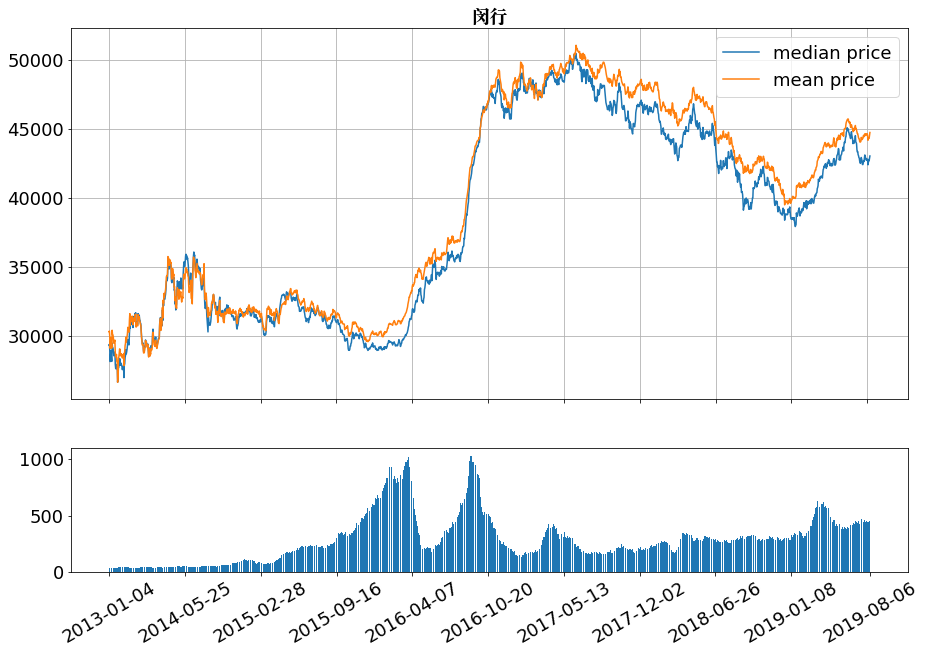

松江


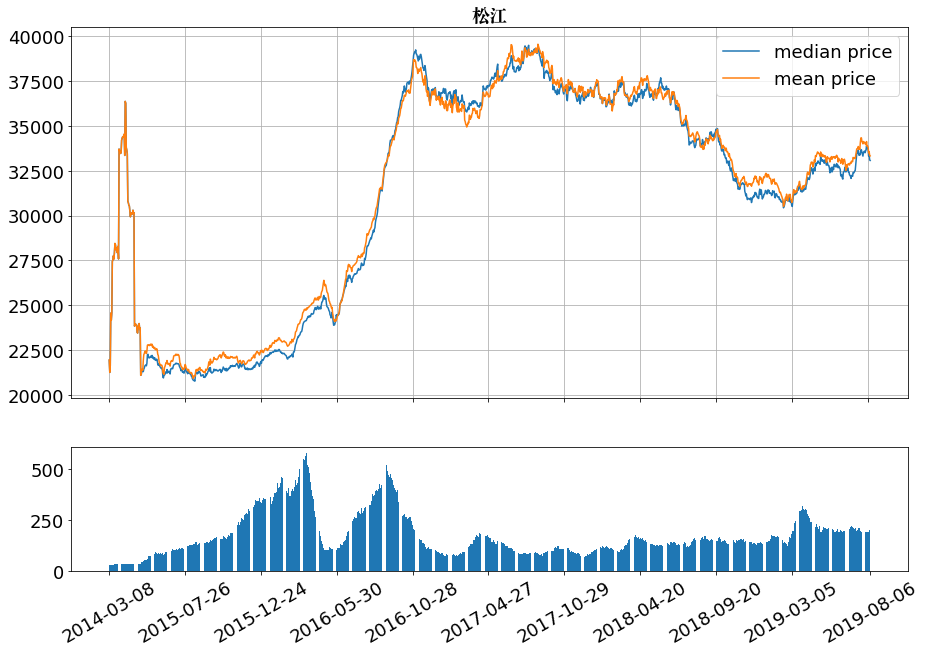

嘉定


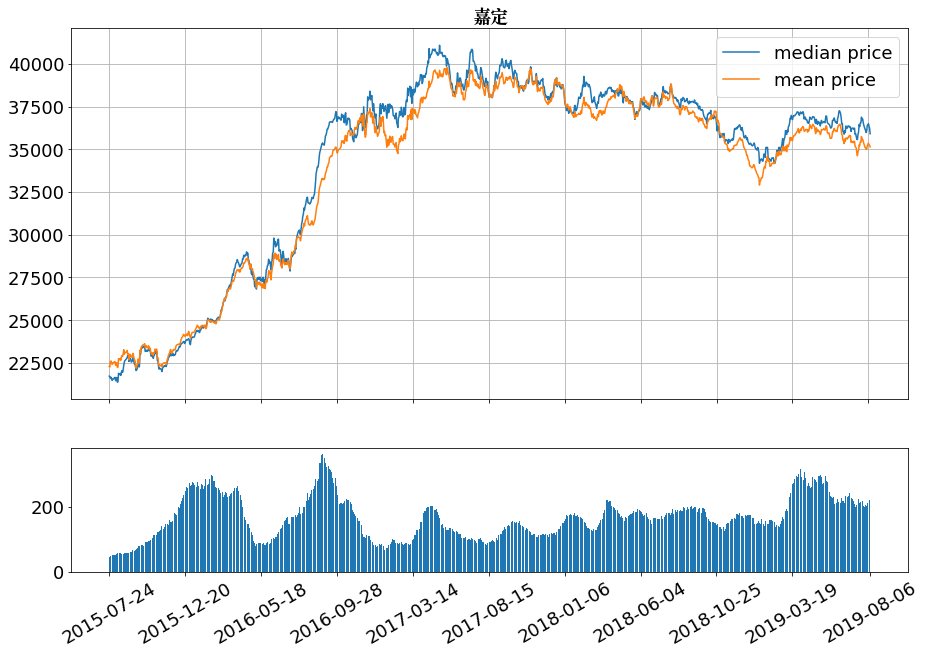

闸北


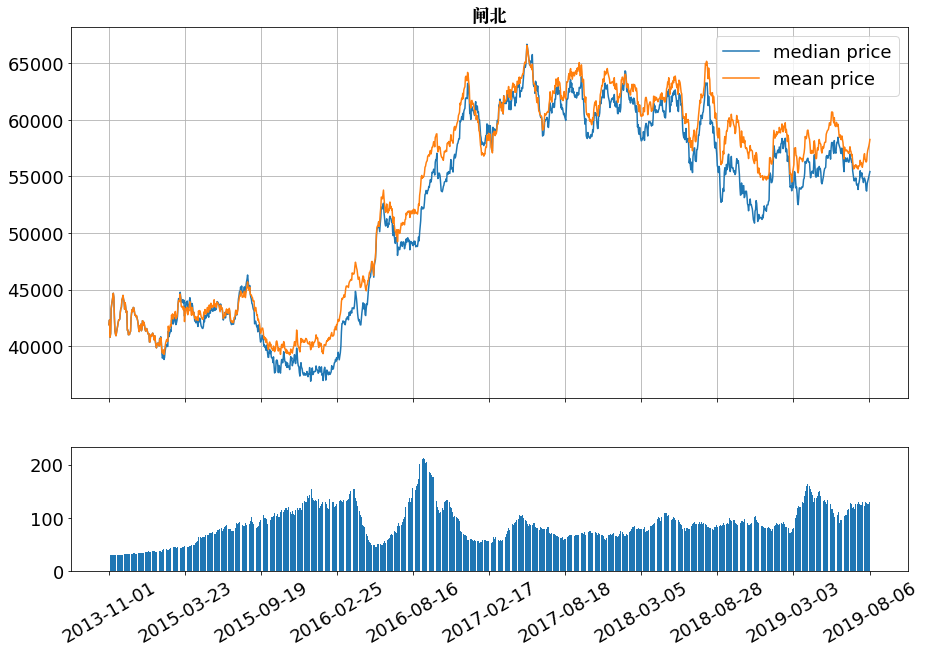

浦东


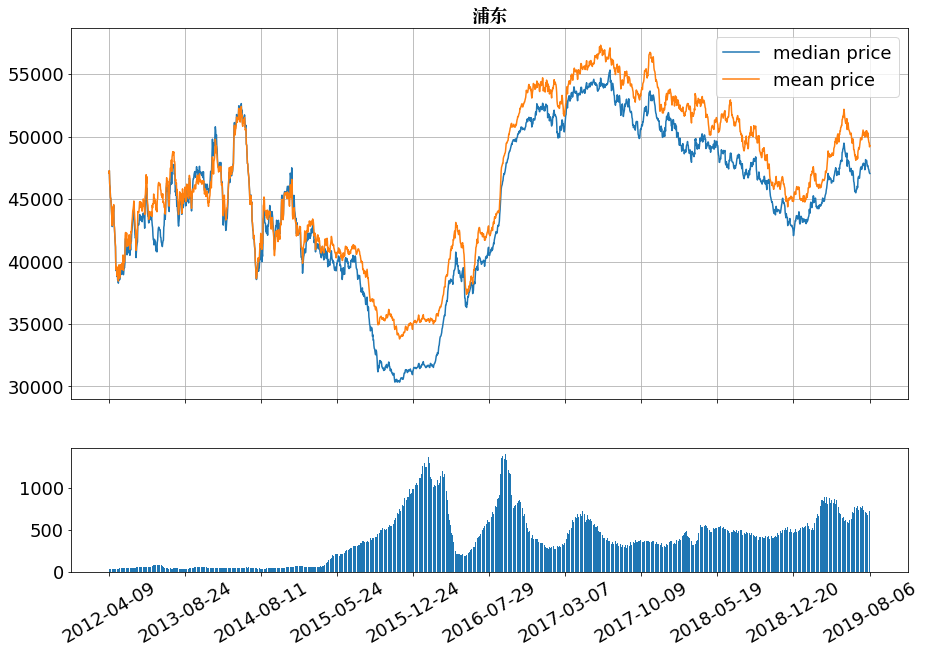

杨浦


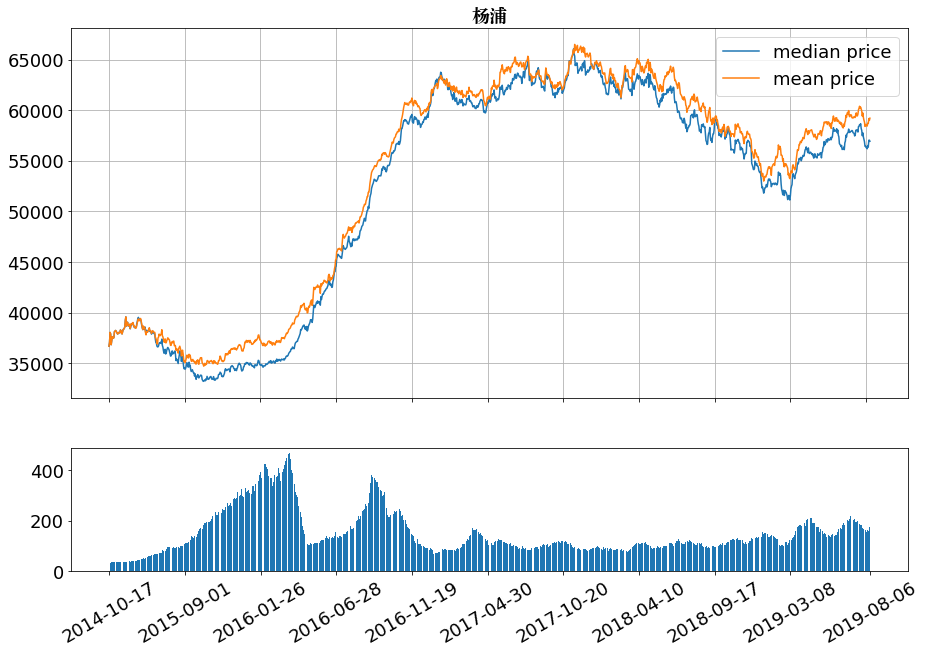

普陀


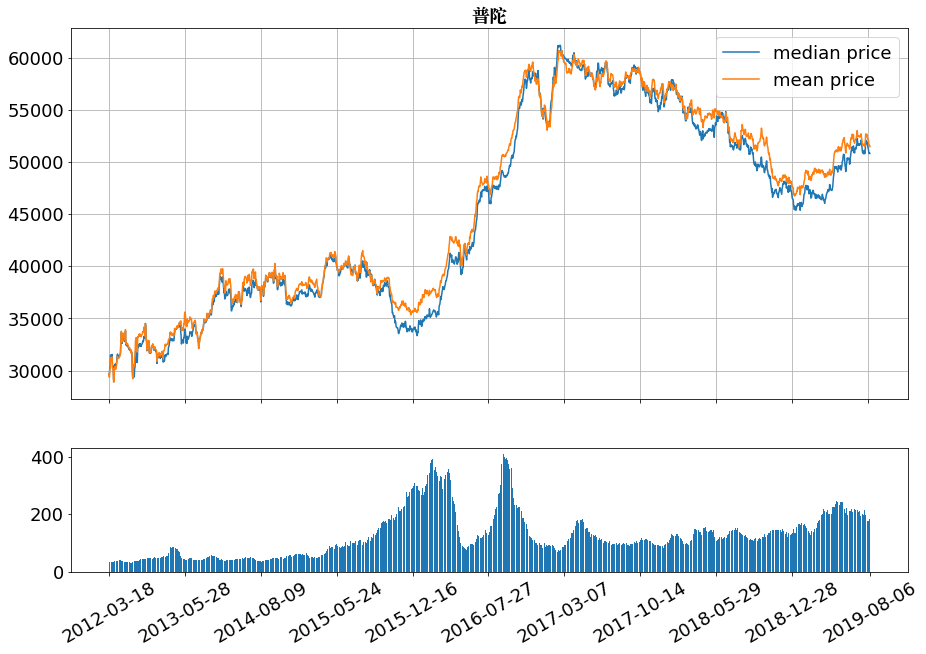

虹口


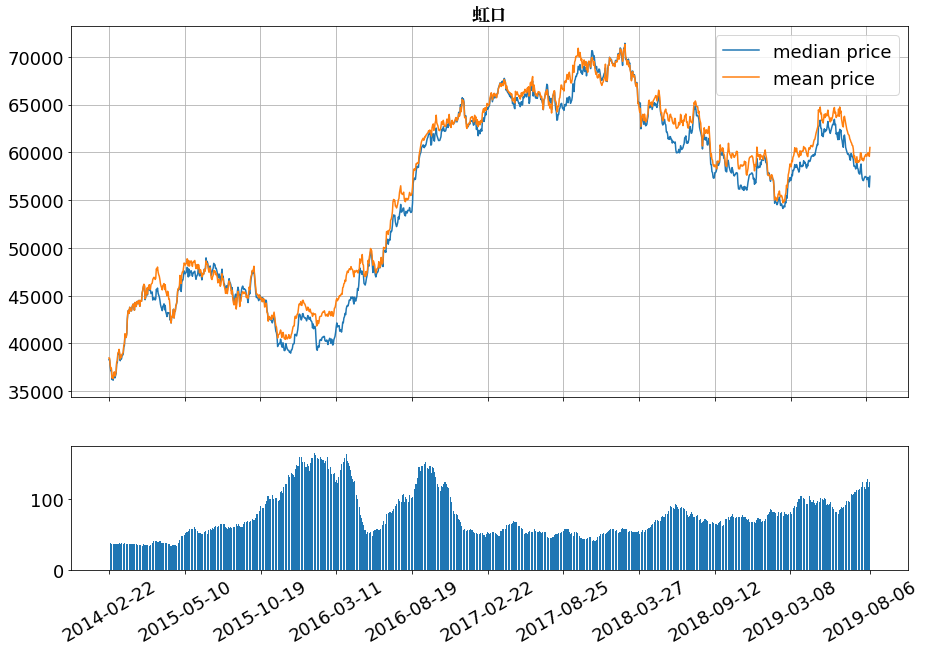

青浦


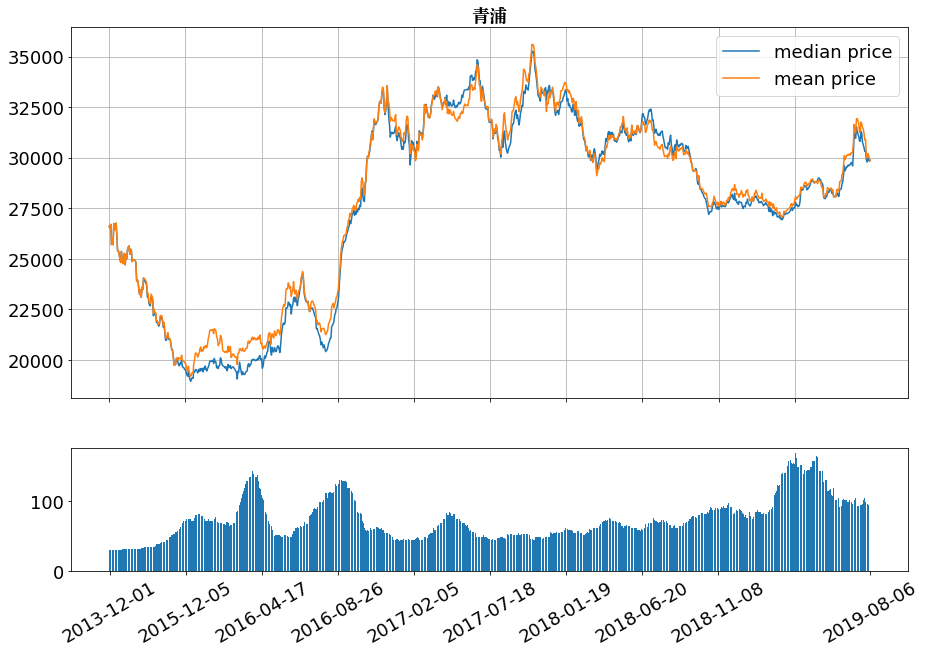

静安


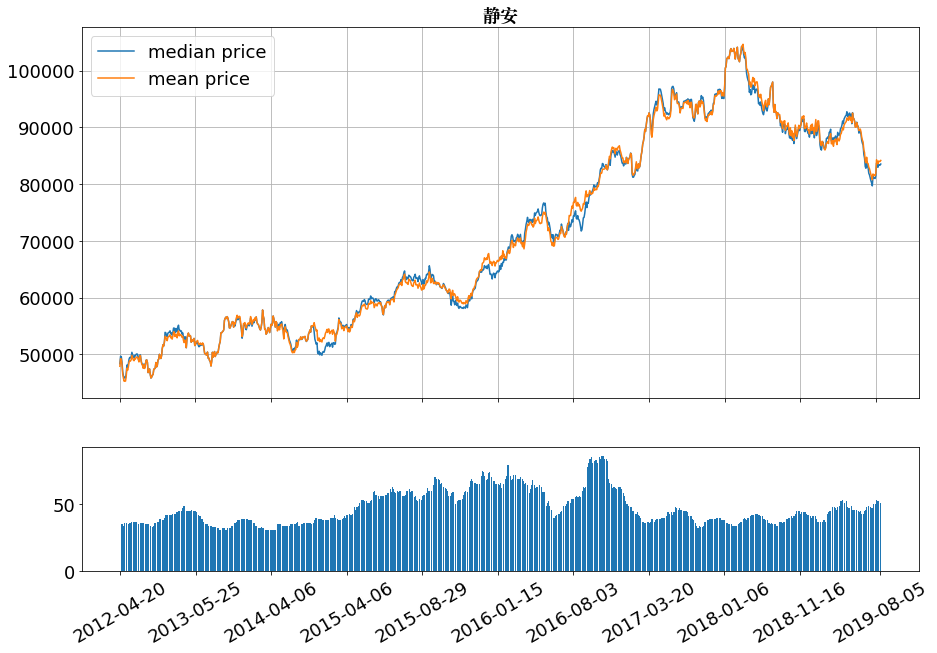

奉贤


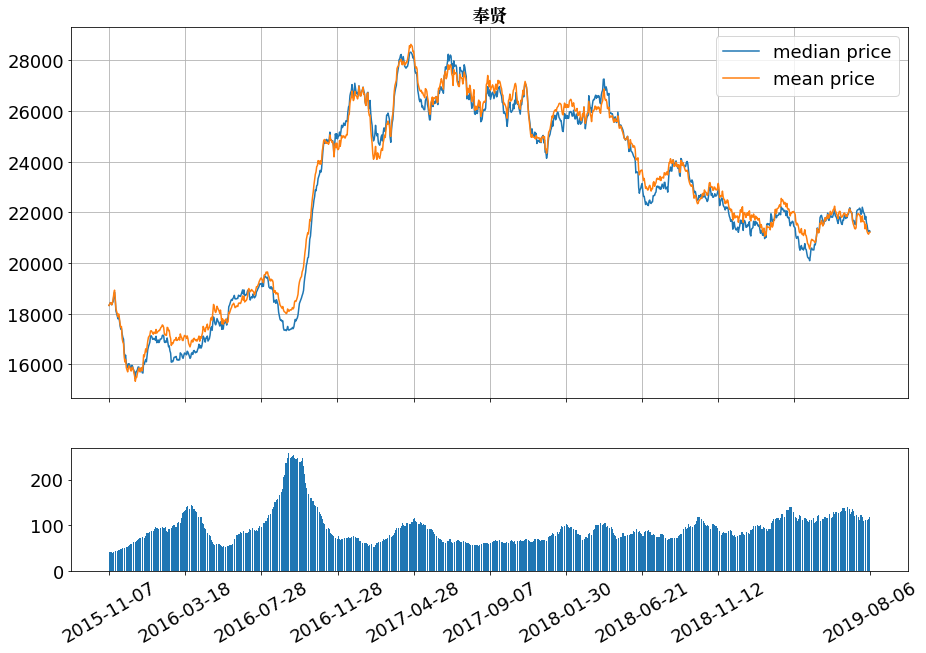

金山
崇明


In [7]:
from common import plot_df, plot_district, plot
import pandas as pd
from pypinyin import pinyin
MA = True
#MA = False
ma_length = 30
start_date = None#'2017-01-01'

gp = df.groupby(['成交时间'])['成交价(元/平)']
res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
res = res.iloc[:len(res)-1,:]
title = city
plot(res, city, title, MA, ma_length, start_date)

districts = list(df['下辖区'].unique())
for district in districts:
    if str(district) != 'nan':
        plot_district(df, city, district, ma_length, start_date)

In [ ]:
from common import plot_df
df_sjs = df.loc[df['下辖区']=='石景山']
xiaoquList = df_sjs['小区'].unique()
for xiaoqu in xiaoquList:
    plot_df(df_sjs.loc[df_sjs["小区"]== xiaoqu], "石景山", xiaoqu, True, 10)

In [ ]:
import pandas as pd
x=df_sjs.groupby('小区')

x_mean  = x.mean()
x_size = x.size()
x_mean = x_mean.merge(pd.DataFrame({'size':x_size}), left_index = True, right_index = True)
x_mean=x_mean.loc[x_size>=5]
x_mean=x_mean.sort_values(by='成交价(元/平)', ascending=False).loc[:,["建筑面积","成交价(元/平)","售价(万)", 'size']]
x_mean

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


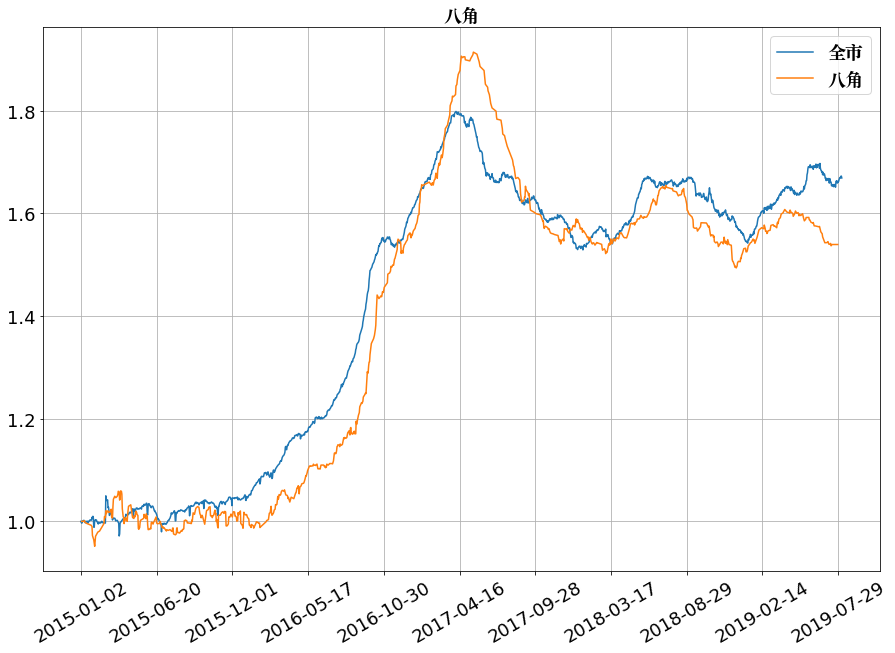

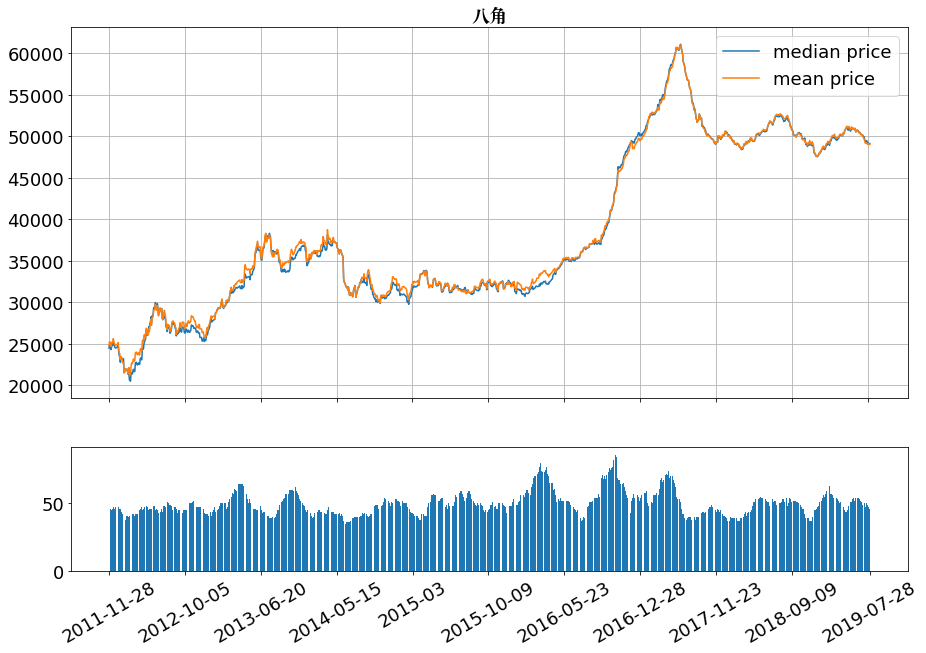

In [5]:
from common import plot, plot_dfs, plot_df
MA = True
ma_length = 10
def plot_xiaoqu(xiaoqu, df):
    df_xiaoqu = df.dropna(subset=['小区'])
    df_xiaoqu = df_xiaoqu.loc[df_xiaoqu['小区'].str.contains(xiaoqu)]
    plot_dfs([df, df_xiaoqu], xiaoqu, ['全市', xiaoqu], ma_length, '2015-01-01')
    plot_df(df_xiaoqu, city, xiaoqu, MA, ma_length)
    
ma_length = 30
plot_xiaoqu('八角', df)

In [ ]:
pd.options.display.max_columns = None
#df.loc[df['小区'].str.contains('团结湖南里')]
df.loc[df['小区'].str.contains('爱乐')].sort_values(by='成交时间', ascending=False)
#df.loc[df['小区'].str.contains('平乐园')].sort_values(by='成交时间', ascending=False)

In [ ]:
x=df.groupby('小区')
x_mean  = x.mean()
x_size = x.size()
#x_size
x_mean=x_mean.loc[x_size>=1]
x_mean=x_mean.sort_values(by='成交价(元/平)', ascending=False).loc[:,["建筑面积","成交价(元/平)","售价(万)"]]
x_mean

In [ ]:
x_mean.index[:10]

In [ ]:
df.sort_values('售价(万)', ascending=False).loc[:,["小区", "建筑面积","成交价(元/平)", "售价(万)"]]

In [ ]:
df.sort_values('成交价(元/平)', ascending=False).loc[:,["小区", "建筑面积","成交价(元/平)", "售价(万)","成交时间"]]

In [ ]:
ma_length = 10
mean_price = df['成交价(元/平)'].mean()
price_std = df['成交价(元/平)'].std()
print('mean:', mean_price, 'std:', price_std)
threshold = 1.3
#high_df = df.loc[df['成交价(元/平)']>= mean_price + threshold * price_std]
#low_df =  df.loc[df['成交价(元/平)']< mean_price - threshold* price_std]
#medium_df = df.loc[df['成交价(元/平)']< mean_price + threshold * price_std]
#medium_df = medium_df.loc[medium_df['成交价(元/平)']>= mean_price - threshold * price_std]
sort_key = '成交价(元/平)'#
#sort_key = '售价(万)'
df = df.sort_values(sort_key, ascending = False)
count = len(df)//3
high_df = df.iloc[:count]
low_df = df.iloc[-count:]
medium_df = df.iloc[count:-count]
print(len(high_df), len(low_df), len(medium_df))
print(high_df[sort_key].mean(), medium_df[sort_key].mean(), low_df[sort_key].mean() )
ma_length = 30
def getPriceSeries(df):
    gp = df.groupby(['成交时间'])['成交价(元/平)']
    res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
    res = res.sort_index()
    res = res.iloc[:len(res)-1]
    res = get_moving_average(res, ma_length)
    return res
highSeries=getPriceSeries(high_df)
mediumSeries=getPriceSeries(medium_df)
lowSeries=getPriceSeries(low_df)


In [ ]:
fig, ax = plt.subplots()
ax.plot(highSeries['mean_price']/highSeries['mean_price'][0])
ax.plot(mediumSeries['mean_price']/mediumSeries['mean_price'][0])
ax.plot(lowSeries['mean_price']/lowSeries['mean_price'][0])
plt.xticks(rotation=45)
ax.legend(['high=%.f yuan'%(high_df[sort_key].mean()),
           'medium=%.f yuan'%medium_df[sort_key].mean(),
           'low=%.f yuan'%low_df[sort_key].mean()])
xticks = ax.xaxis.get_major_ticks()
interval = len(xticks)// 10
ax.set_xticks(ax.get_xticks()[::interval])
'done'

In [ ]:
plt.axis

In [ ]:
plt.plot(highSeries['median_price']/highSeries['median_price'][0])
plt.plot(mediumSeries['median_price']/mediumSeries['median_price'][0])
plt.plot(lowSeries['median_price']/lowSeries['median_price'][0])
plt.xticks(rotation=90)
plt.legend(['high','medium', 'low'])


In [ ]:
def plotAllDistrict(df, ma_length = 10):
    districts = list(set(df['下辖区']))
    legend = ['beijing']
    data = []
    gp = df.groupby(['成交时间'])['成交价(元/平)']
    res=pd.DataFrame({"volume":gp.size(),"median_price":gp.median(), "mean_price":gp.mean()})
    res = res.iloc[:len(res)-1,:]
    res = get_moving_average(res, ma_length)

    data.append(res)
    for district in districts:
        gp = df.loc[df['下辖区']==district].groupby(['成交时间'])
        res = pd.DataFrame({'volume':gp.size(),'mean_price':gp['成交价(元/平)'].mean(), 'median_price':gp['成交价(元/平)'].median()})
        res = res.iloc[:len(res) -1,:]
        res = get_moving_average(res, ma_length)
        if len(res) < 1:
            continue
        data.append(res)
        title = pinyin(district)
        if district == '朝阳':
            title = 'chao yang'
        elif district == '长宁':
            title = 'chang ning'
        elif district == '闵行':
            title = 'min hang'
        else:
            title = " ".join([x[0] for x in title])
        legend.append(title)
   
    for i in range(len(data)):
        plt.plot(data[i]['mean_price']/data[i]['mean_price'].iloc[0])
    plt.xticks(rotation=90)
    plt.legend(legend)
plotAllDistrict(df, 30)
    

In [ ]:
df1 = df.loc[df['售价(万)']>=400]
df2 = df1.loc[df1['售价(万)']<=500]
df2.to_csv('400-500.csv', index=False, encoding ='gbk')